In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.layers.advanced_activations import LeakyReLU 
from keras.preprocessing.image import ImageDataGenerator
from os.path import join as pjoin
from os import path
from PIL import Image

np.random.seed(25)

Using TensorFlow backend.
C:\Users\Rohit.Mishra\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Rohit.Mishra\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Rohit.Mishra\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Us

In [2]:
image_folder_name = "images"
label_path = './module_metadata.json'

In [3]:
if path.exists(image_folder_name):
    print("{} folder is available".format(image_folder_name))
    if path.isdir(image_folder_name):
        print("{} is a directory!! Safe to proceed.".format(image_folder_name))
    else:
        raise ValueError("{} should be a directory but it is not, please verify!".format(image_folder_name))
else:
    raise ValueError("{} folder does not exist".format(image_folder_name))

images folder is available
images is a directory!! Safe to proceed.


In [4]:
def read_image(img_path = None):
    
    relative_image_path = pjoin('./', img_path) 
    
    img = Image.open(relative_image_path)
    
    if img.size != (24,40):
        raise ValueError("{} image needs resizing".format(img_path))
    
    arr = np.array(img)
    
    arr = arr.reshape((arr.shape[0], arr.shape[1], 1))
    
    return arr

In [5]:
label_path = './module_metadata.json'

In [6]:
if path.exists(label_path):
    print("{} is present".format(label_path))
    if 'json' in label_path:
        print("{} is a JSON file!! Safe to proceed.".format(label_path))
    else:
        raise ValueError("{} should be a JSON but it is not, please verify!".format(label_path))
else:
    raise ValueError("{} file does not exist".format(label_path))

./module_metadata.json is present
./module_metadata.json is a JSON file!! Safe to proceed.


In [7]:
label_df = pd.read_json(label_path, orient='index')

In [8]:
label_df.head()

,image_filepath,anomaly_class
13357,images/13357.jpg,No-Anomaly
13356,images/13356.jpg,No-Anomaly
19719,images/19719.jpg,No-Anomaly
11542,images/11542.jpg,No-Anomaly
11543,images/11543.jpg,No-Anomaly


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(label_df[['image_filepath']], 
                                                    label_df[['anomaly_class']], test_size=0.2, \
                                                    shuffle= True,random_state=42, stratify = label_df[['anomaly_class']])

In [10]:
import random
random_number = random.randint(0,label_df.shape[0])
print("Dimension of each image:{}".format(read_image(img_path = label_df['image_filepath'][random_number]).shape))

Dimension of each image:(40, 24, 1)


In [11]:
X_train_array = []
for index, row in X_train.iterrows():
    X_train_array.append(read_image(img_path = row['image_filepath']))

X_train_array = np.array(X_train_array)

In [12]:
X_test_array = []
for index, row in X_test.iterrows():
    X_test_array.append(read_image(img_path = row['image_filepath']))
    
X_test_array = np.array(X_test_array)

In [13]:
np.array(X_train_array).shape, np.array(X_test_array).shape 

((15922, 40, 24, 1), (3981, 40, 24, 1))

In [14]:
def encoding(array = None, _type = 'train', encod_l = None, encod_o = None):
    
    from sklearn.preprocessing import LabelEncoder
    from sklearn.preprocessing import OneHotEncoder

    if _type == 'train':
        label_encoder = LabelEncoder()
        onehot_encoder = OneHotEncoder(sparse=False)
    else:
        label_encoder = encod_l
        onehot_encoder = encod_o
    
    integer_encoded = label_encoder.fit_transform(array)
    print(integer_encoded)
    
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded_y = onehot_encoder.fit_transform(integer_encoded)
    return onehot_encoded_y,label_encoder, onehot_encoder


In [15]:
y_train_encoded, label_encoder, onehot_encoder = encoding(array = y_train['anomaly_class'].to_numpy(), 
                                                          _type = 'train', 
                                                          encod_l = None, 
                                                          encod_o = None)

y_test_encoded, _, _ = encoding(array = y_test['anomaly_class'].to_numpy(), 
                                _type = 'test', 
                                encod_l = label_encoder, 
                                encod_o = onehot_encoder)

[ 7  0  7 ...  8  7 11]
[ 1  7 11 ...  7  7  7]


In [17]:
import pickle

output = open('label_encoder.pkl', 'wb')
pickle.dump(label_encoder, output)
output.close()

output_ = open('onehot_encoder.pkl', 'wb')
pickle.dump(onehot_encoder, output_)
output.close()

In [18]:
X_train_array = X_train_array.astype('float32')
X_test_array = X_test_array.astype('float32')

In [19]:
X_train_array/=255
X_test_array/=255

In [20]:
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(40,24,1)))
model.add(Activation('relu'))
BatchNormalization(axis=-1)
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

BatchNormalization(axis=-1)
model.add(Conv2D(64,(3, 3)))
model.add(Activation('relu'))
BatchNormalization(axis=-1)
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
# Fully connected layer

BatchNormalization()
model.add(Dense(512))
model.add(Activation('relu'))
BatchNormalization()
model.add(Dropout(0.2))
model.add(Dense(12))

model.add(Activation('softmax'))

In [21]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 38, 22, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 38, 22, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 36, 20, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 36, 20, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 10, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 8, 64)         18496     
_________________________________________________________________
activation_3 (Activation)    (None, 16, 8, 64)         0         
__________

In [22]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [23]:
gen = ImageDataGenerator()

test_gen = ImageDataGenerator()

In [24]:
train_generator = gen.flow(X_train_array, y_train_encoded, batch_size=64)
test_generator = test_gen.flow(X_test_array, y_test_encoded, batch_size=64)

In [25]:
history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=10, 
                    validation_data=test_generator, validation_steps=100)

Epoch 1/10
100/100 [==============================] - 348s 3s/step - loss: 1.8473 - acc: 0.4958 - val_loss: 1.7682 - val_acc: 0.5009
Epoch 2/10
100/100 [==============================] - 311s 3s/step - loss: 1.7495 - acc: 0.5083 - val_loss: 1.7734 - val_acc: 0.5009
Epoch 3/10
100/100 [==============================] - 311s 3s/step - loss: 1.7720 - acc: 0.4924 - val_loss: 1.7515 - val_acc: 0.5009
Epoch 4/10
100/100 [==============================] - 343s 3s/step - loss: 1.7368 - acc: 0.5075 - val_loss: 1.7405 - val_acc: 0.5009
Epoch 5/10
100/100 [==============================] - 335s 3s/step - loss: 1.7428 - acc: 0.4944 - val_loss: 1.7470 - val_acc: 0.5009
Epoch 6/10
100/100 [==============================] - 305s 3s/step - loss: 1.7327 - acc: 0.5002 - val_loss: 1.7420 - val_acc: 0.5009
Epoch 7/10
100/100 [==============================] - 326s 3s/step - loss: 1.7333 - acc: 0.4998 - val_loss: 1.7116 - val_acc: 0.5011
Epoch 8/10
100/100 [==============================] - 379s 4s/step - 

In [26]:
model.save('JUA_baseline.h5')

In [27]:
pd.DataFrame.from_dict(history.history).to_csv('history.csv',index=False)

Text(0, 0.5, 'Training/Validation loss')

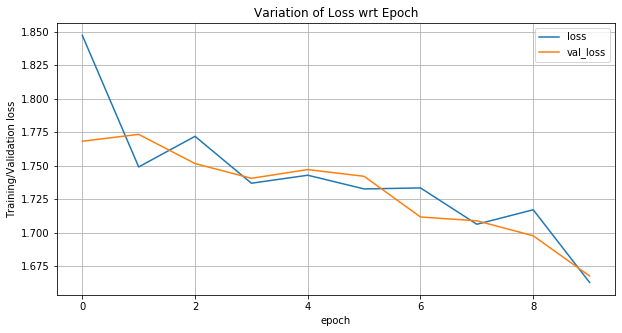

In [28]:
losses = pd.read_csv('./history.csv')
losses[['loss','val_loss']].plot(grid=True,figsize=(10,5))
plt.title('Variation of Loss wrt Epoch')
plt.xlabel('epoch')
plt.ylabel('Training/Validation loss')

Text(0, 0.5, 'Training/Validation accuracy')

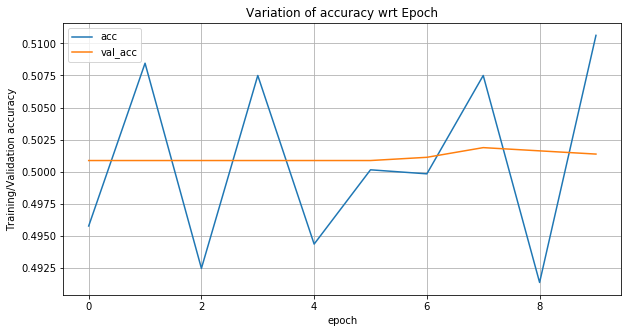

In [29]:
losses[['acc','val_acc']].plot(grid=True,figsize = (10,5))
plt.title('Variation of accuracy wrt Epoch')
plt.xlabel('epoch')
plt.ylabel('Training/Validation accuracy')

In [30]:
def prediction(test_image_path = None):
    
    test_image_array = []
    
    test_image = read_image(img_path = test_image_path)
    
    print(test_image.shape)
    
    test_image_array.append(test_image)
    test_image_array = np.array(test_image_array)
    
    print(test_image_array.shape)
    
    test_image_array = test_image_array.astype('float32')
    
    test_image_array/=255
    
    model = keras.models.load_model('JUA_baseline.h5')
    
    prediction = model.predict_classes(test_image_array)
    
    print(np.round(model.predict_proba(test_image_array)[0][prediction][0]*100,2))
    pickle_file = open("label_encoder.pkl", "rb")
    
    label_encoder = pickle.load(pickle_file)
    
    prediction = label_encoder.inverse_transform(prediction)
    
    return prediction[0]

In [31]:
prediction(test_image_path = './prediction/1744.jpg')

(40, 24, 1)
(1, 40, 24, 1)
38.56


'No-Anomaly'

In [32]:
label_df[label_df['image_filepath']=='images/1744.jpg']

,image_filepath,anomaly_class
1744,images/1744.jpg,Diode
